In [45]:
from music21 import *
from itertools import permutations
pitch.Pitch.__repr__ = pitch.Pitch.__str__

In [46]:
carter = converter.parse('carter_gra_mxl.mxl')

# Helper Functions

### - Normal Form

In [47]:
def perm_list(pitch_list, rotation_amount=1):
    """Rotates a list by rotation_amount"""
    return pitch_list[rotation_amount:] + pitch_list[:rotation_amount]

In [48]:
def check_compactness(pitch_classes, index = -1):
    """Checks distance between first and last notes"""
    return (pitch_classes[index] - pitch_classes[0]) % 12

In [49]:
def check_equal(list1, list2, index):
    """Checks equality if there is a tie for the best intervals between pitches when finding the normal form"""
    if index == -len(list1): # if the lists have equal pitches classes all the way down. Take the one with the lowest starting pitch class
        if list1[0] < list2[0]:
            return list1
        return list2
    if check_compactness(list1, index) == check_compactness(list2, index):
        return check_equal(list1, list2, index-1)
    elif check_compactness(list1, index) < check_compactness(list2, index):
        return list1
    return list2

In [50]:
def most_compact(pitches):
    best_interval, best_pitches = check_compactness(pitches), pitches
    for i in range(len(pitches)):
        rotation = perm_list(pitches, i)
        compactness = check_compactness(rotation)
        if compactness < best_interval:
            best_interval = compactness
            best_pitches = rotation
        if compactness == best_interval:
            best_pitches = check_equal(best_pitches, rotation, index=-2)
    return best_pitches

In [51]:
def reduce_to_normal_form(pitch_list):
    """
    Given a list of musci21 pitch objects, reduces them to their normal form as a 
    list of integers.
    """
    pitch_classes = sorted(list(set(x.pitchClass for x in pitch_list)))
    normal_form = most_compact(pitch_classes)
    return normal_form


In [52]:
# Tests for normal form
def test_normal_form():
    """Runs test cases for the reduction to normal form"""
    P = pitch.Pitch
    pc_ex = [P('C4'), P('C#4'), P('C3'), P('B3')]
    pc1 = [P('Ab4'), P('D4'),P('Eb5'), P('A4')]
    pc2 = [P('B5'), P('G4'), P('D5'), P('Eb'), P('D6')]
    assert reduce_to_normal_form(pc1) == [2,3,8,9]
    assert reduce_to_normal_form(pc_ex) == [11,0,1]
    assert reduce_to_normal_form(pc2) == [11,2,3,7]
    pass
test_normal_form()

### - Prime Form


In [53]:
def transpose_normal(pitch_classes):
    """Given a list of pitch classes in normal form, transposes them to start on C."""
    return [(x+12 - pitch_classes[0])%12 for x in pitch_classes]


In [54]:
def invert_transpose(pitch_classes):
    """Given a list of pitch classes in normal form, transposes them to start on C, then inverts 
    them, then put the inverted form into increasing order."""
    transposed = [(x+12 - pitch_classes[0])%12 for x in pitch_classes]
    inverted = [(-x)%12 for x in transposed]
    increasing = perm_list(sorted(inverted), 1)
    return increasing, transposed

In [55]:
lis = [0,3,4,8]
invert_transpose([0,3,4,8])

([4, 8, 9, 0], [0, 3, 4, 8])

In [56]:
def reduce_to_prime_form(pitch_list, stringify = False):
    """reduces a pitch list to prime form. If stringify = True, then returns the answer as a string. """
    
    inverted, transposed_normal  = invert_transpose(pitch_list)
    best_inverted = most_compact(inverted)
    if check_compactness(best_inverted,) == check_compactness(transposed_normal):
        anslist = check_equal(best_inverted, transposed_normal, index=-2)
    elif check_compactness(best_inverted,) < check_compactness(transposed_normal):
        anslist = best_inverted
    elif check_compactness(best_inverted,) > check_compactness(transposed_normal):
        anslist =  transposed_normal
    transpose2 = transpose_normal(anslist)
    if not stringify:
        return transpose2
    prime_form = ''
    for x in transpose2:
        if x ==10:
            x = 'T'
        elif x == 11:
            x = 'E'
        prime_form = prime_form + str(x)
    return prime_form

    

In [57]:
def test_prime_form():
    """Tests the function reduce_to_prime_form"""
    assert reduce_to_prime_form([11,2,3,7], stringify=True) == '0148'
    assert reduce_to_prime_form([11,2,3,7]) == [0,1,4,8]
    pass


In [58]:
#TODO: add more test cases
test_prime_form()

### - Interval Vectors

In [59]:
def get_interval_vector(pitch_list, zero = False):
    """Given a list of pitches, returns the interval vector between all of the pitches. 
    If zero = true, returns the interval vector that includes 0.
    """
    intervals = {}
    for i in range(len(pitch_list)):
        for j in range(len(pitch_list)-i):
            diff = pitch_list[j+i]-pitch_list[i]
            if diff >6:
                diff = 12-diff
            if diff in intervals:
                intervals[diff] +=1
            else:
                intervals[diff] = 1
    interval_vector = []
    for i in range(7):
        if i in intervals:
            interval_vector.append(intervals[i])
        else:
            interval_vector.append(0)
    if zero:
        return interval_vector
    return interval_vector[1:]

In [60]:
P = pitch.Pitch
def test_interval_vector():
    a = reduce_to_prime_form([11,2,3,7], stringify=False)
    g_half_dim = [P('G4'), P('Bb4'), P('Db5'), P('F5') ]
    G_normal = reduce_to_normal_form(g_half_dim)
    G_prime = reduce_to_prime_form(G_normal)
    assert get_interval_vector(G_prime) == [0,1,2,1,1,1]
    assert get_interval_vector(a) == [1,0,1,3,1,0]
test_interval_vector()

In [61]:
def pitch_to_int_vec(pitch_list):
    """Combines the whole normal -> prime -> interval vector pathway. Takes in a pitch list and returns its interval vector."""
    return get_interval_vector(reduce_to_prime_form(reduce_to_normal_form(pitch_list)))

In [62]:
def test_ptiv():
    g_half_dim = [P('G4'), P('Bb4'), P('Db5'), P('F5') ]
    assert pitch_to_int_vec(g_half_dim) == [0,1,2,1,1,1]
test_ptiv()

### Windowing Functions

In [63]:
def check_window(notes):
    """Given a set of pitches, check it for 4-Z29 or 4-Z15. If we find it, returns the pitch_set that was found as the Z-relation. 
    
    This is a factorial algorithm if we use all the notes!
    TODO: MAKE FASTER? Do we need to check every permutation? No we do not? remove duplicate notes first? Probably should add some 
    logic that takes into account ordering or something. More work to be done. """
    z_relations = []
    seen = []
    for n in permutations(notes, r=4):
        if pitch_to_int_vec(n) == [1,1,1,1,1,1]: # we have found a z-relation
         # but we are checking every permutation. There are going to be like 1000 out of order duplicates, we need to get rid of these
            pitches = set(x.pitchClass for x in n)
            if pitches in seen:
                continue
            else:
                if n in z_relations:
                    continue
                z_relations.append(n)
                seen.append(pitches)
    return z_relations

In [64]:
def bits_to_int(bits):
    '''Converts a vector of 0/1 bits into a single number in binary (in reading order)'''
    ans = 0
    for b in bits:
        ans = ans << 1
        ans += b
    return ans

def int_to_bits(i):
    '''Converts a positive integer of 24 binary digits into an 24-bit bit vector in reading order'''
    ans = []
    for _ in range(24):
        ans.append(i & 1)
        i = i >> 1
    return ans[::-1]

def notes_to_int(notes):
    '''
    Reduces a set of notes under OPCS and converts into a 12-bit vector based off of the presence of each
    note, and returns the integer corresponding to said bitvector.
    '''
    bits = [0] * 12
    for n in notes:
        bits[n.pitch.pitchClass] = 1
    return bits_to_int(bits)
    
def bits_to_pitches(bits):
    '''
    Turns a bit vector into a list of pitches by including a pitch of the corresponding MIDI value or pitch class
    if the bit is one.
    '''
    return [pitch.Pitch(i) for i, b in enumerate(bits) if b != 0]

def values_to_bits(values):
    '''Turns a list of integers at most 12 into the corresponding incidence bit-vector'''
    bits = [0] * 12
    for v in values:
        bits[v] = 1
    return bits

In [65]:
def check_window_fast(notes):
    """Given a set of pitches, check it for 4-Z29 or 4-Z15.
    If we find it, returns the pitch_set that was found as the Z-relation. 
    """
    reduced = notes_to_int(notes)
    reduced = (reduced << 12) + reduced
    
    patterns = [[0, 1, 3, 7], [0, 1, 4, 6], [11, 10, 8, 4], [11, 10, 7, 5]]
    patterns_ints = [bits_to_int(values_to_bits(p)) for p in patterns]
    z_relations = []
    for p in patterns_ints:
        for offset in range(12):
            shifted = p << offset
            if (shifted & reduced) == shifted:
                shifted_pitches = bits_to_pitches(int_to_bits((shifted)))
                z_relations.append(shifted_pitches)
    return z_relations

In [68]:
bach = corpus.parse('bwv253')
test_set = bach.measures(0, 2)[note.Note]

In [69]:
import time
start = time.time()
for i in range(1000):
    check_window(list(set(pitch.Pitch(n.name) for n in test_set)))
end = time.time()
print(end - start)

33.271568775177


In [70]:
import time
start = time.time()
for i in range(1000):
    check_window_fast(test_set)
end = time.time()
print(end - start)

0.42636895179748535


# Main Function

In [71]:
MEASURE = 'measures'
NOTES = 'notes'
QL = 'quarterLengths'

def get_len(sc, unit):
    '''Given a score object and a unit of measurement, returns the length of the score.'''
    if unit == MEASURE:
        return len(sc[stream.Measure])
    elif unit == NOTES:
        return len(sc[note.Note])
    elif unit == QL:
        return int(sc.duration.quarterLength)
    else:
        assert False, 'Unknown unit of measurement. Only known measurements are ' + ' ' .join(MEASURE, NOTES, QL)

def get_window_generator(sc, window_size, window_shift, unit):
    '''
    Given a score object, a window size, a window shift amount, and a unit of measurement,
    returns a generator that yields the items in each window.
    '''
    if unit == MEASURE:
        return measure_generator(sc, window_size, window_shift, get_len(sc, unit))
    elif unit == NOTES:
        return note_generator(sc, window_size, window_shift)
    elif unit == QL:
        return ql_generator(sc, window_size, window_shift)
    else:
        assert False, 'Unknown unit of measurement. Only known measurements are ' + ' ' .join(MEASURE, NOTES, QL)


def measure_generator(sc, window_size, window_shift, total_len):
    '''Generates measure-based windows of the appropriate window size and shift'''
    curr = 0
    while curr <= total_len:
        yield curr, list(sc.measures(curr, curr + window_size)[note.Note])
        curr += window_shift
        
def note_generator(sc, window_size, window_shift):
    '''Generates note count-based windows of the appropriate window size and shift'''
    all_notes = sc.flatten()[note.Note]
    note_cache = []
    for i in range(window_size):
        try:
            note_cache.append(next(all_notes))
        except StopIteration:
            break
    
    done = False
    curr = 0
    while not done:
        yield curr, note_cache
        done = True
        for i in range(window_shift):
            try:
                note_cache[curr % window_size] = next(all_notes)
            except StopIteration:
                break
            done = False
            curr += 1
                
def single_ql(all_notes, curr_note, curr_offset):
    '''
    Returns the notes starting between curr_offset and curr_offset + 1 assuming that curr_note
    is the first note starting at or after curr_offset
    '''
    in_curr = []
    while curr_note is not None and curr_note.offset < curr_offset + 1:
        in_curr.append(curr_note)
        try:
            curr_note = next(all_notes)
        except StopIteration:
            curr_note = None
    return curr_note, in_curr

def flatten(ql_cache):
    '''Flattens the ql_cache from 2d array to 1d array'''
    ans = []
    for ql in ql_cache:
        ans.extend(ql)
    return ans

def ql_generator(sc, window_size, window_shift):
    '''Generates offset-based windows of the appropriate window size and shift'''
    all_notes = sc.flatten()[note.Note]
    ql_cache = []
    try:
        curr_note = next(all_notes)
    except StopIteration:
        return
    
    curr_offset = 0
    for _ in range(window_size):
        curr_note, in_curr = single_ql(all_notes, curr_note, curr_offset)
        ql_cache.append(in_curr)
        curr_offset += 1
    
    yield curr_offset, flatten(ql_cache)
    while curr_note is not None:
        for _ in range(window_shift):
            curr_note, in_curr = single_ql(all_notes, curr_note, curr_offset)
            ql_cache[curr_offset % window_size] = in_curr
            curr_offset += 1
        yield curr_offset, flatten(ql_cache)

In [106]:
def find_Z_relation(sc, window_size, unit = 'measures'):
    """Given a score object and an integer window size and a unit of either 'measures,' 'notes,' or 'quarterLengths,'
    identifies and labels where Z relations occur in the piece where each such chord fits within a window.
    A window size of 1 will cause infinite loop.
    The quarterLengths window only considers the notes that start sounding within the given window.
    For polyphonic pieces, the 'notes' metric just uses the number of intervening notes after flattening as the metric.
    Returns a dictionary that maps windowed measure numbers to Z-relations."""
    shift_len = int(window_size/2)
    Z_rel_dict = {(0,0, unit):[]}
    Z_rel_count = 0
    for n in sc[note.Note]:
        n.lyrics = []
        
    window_generator = get_window_generator(sc, window_size, shift_len, unit)
    
    prev = 0
    prev_window = 0
    while True:
        
        try:
            curr, window = next(window_generator)
        except StopIteration:
            break

        checked = check_window_fast(window)
        if len(checked) ==0:
            continue
        Z_rel_dict[(curr, curr + window_size, unit)] = checked
        for Z_relation in checked:
            if Z_relation in Z_rel_dict[(prev, prev+prev_window, unit)]:
                continue
            pitch_classes = [p.pitchClass for p in Z_relation]
            for n in window:
                if n.pitch.pitchClass in pitch_classes:
                    n.addLyric(str(Z_rel_count))
            Z_rel_count += 1
        prev, prev_window = curr, window_size
    Z_rel_dict.pop((0,0, unit))
    return Z_rel_dict
        


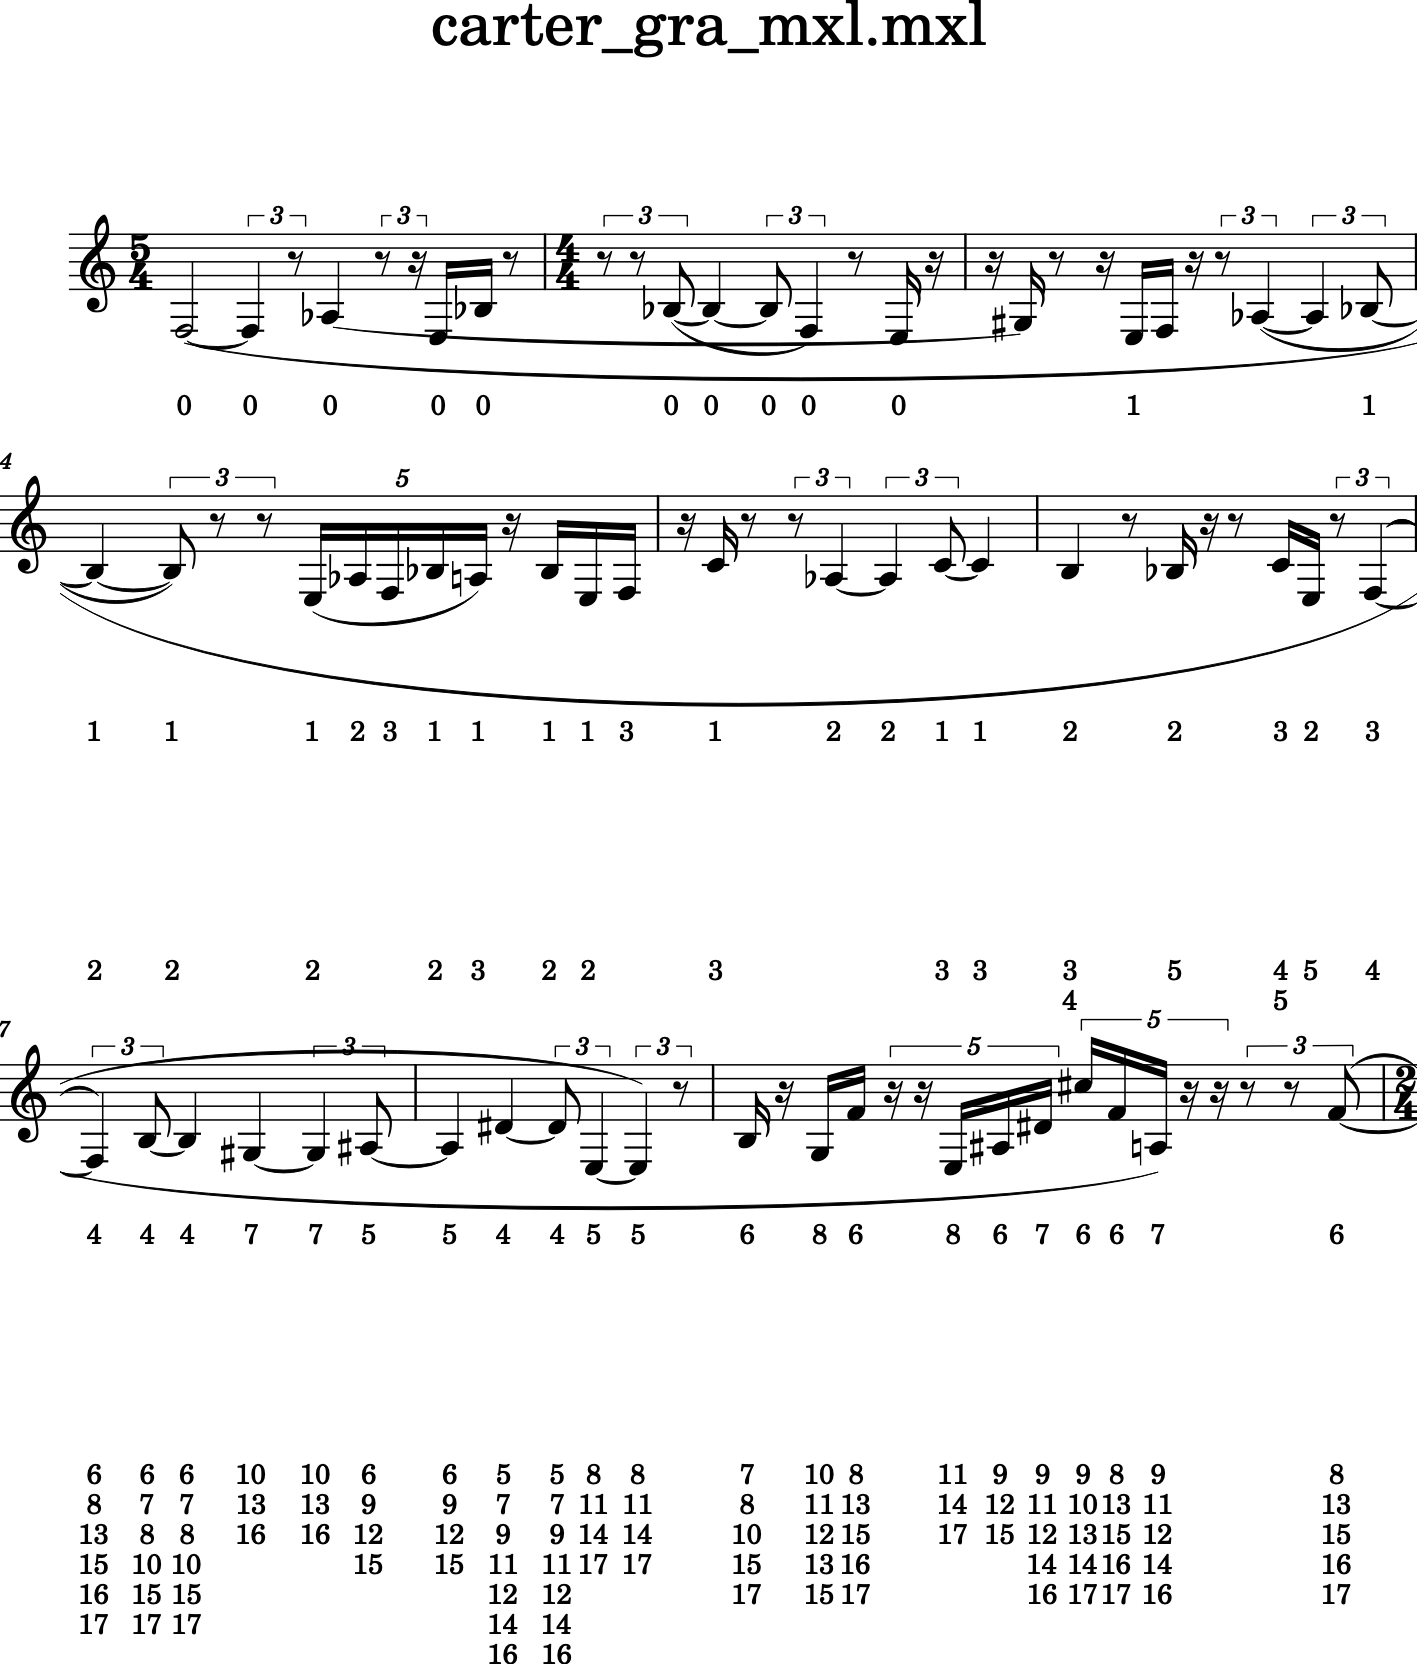

In [107]:
find_Z_relation(carter, 2, 'measures')
carter.measures(0, 20).show()
# print('test')

In [103]:
find_Z_relation(carter, 10, 'notes')
#carter.measures(0, 20).show()
# print('test')

0 10


{(0, 10, 'notes'): [[E, F, G#, B-]]}

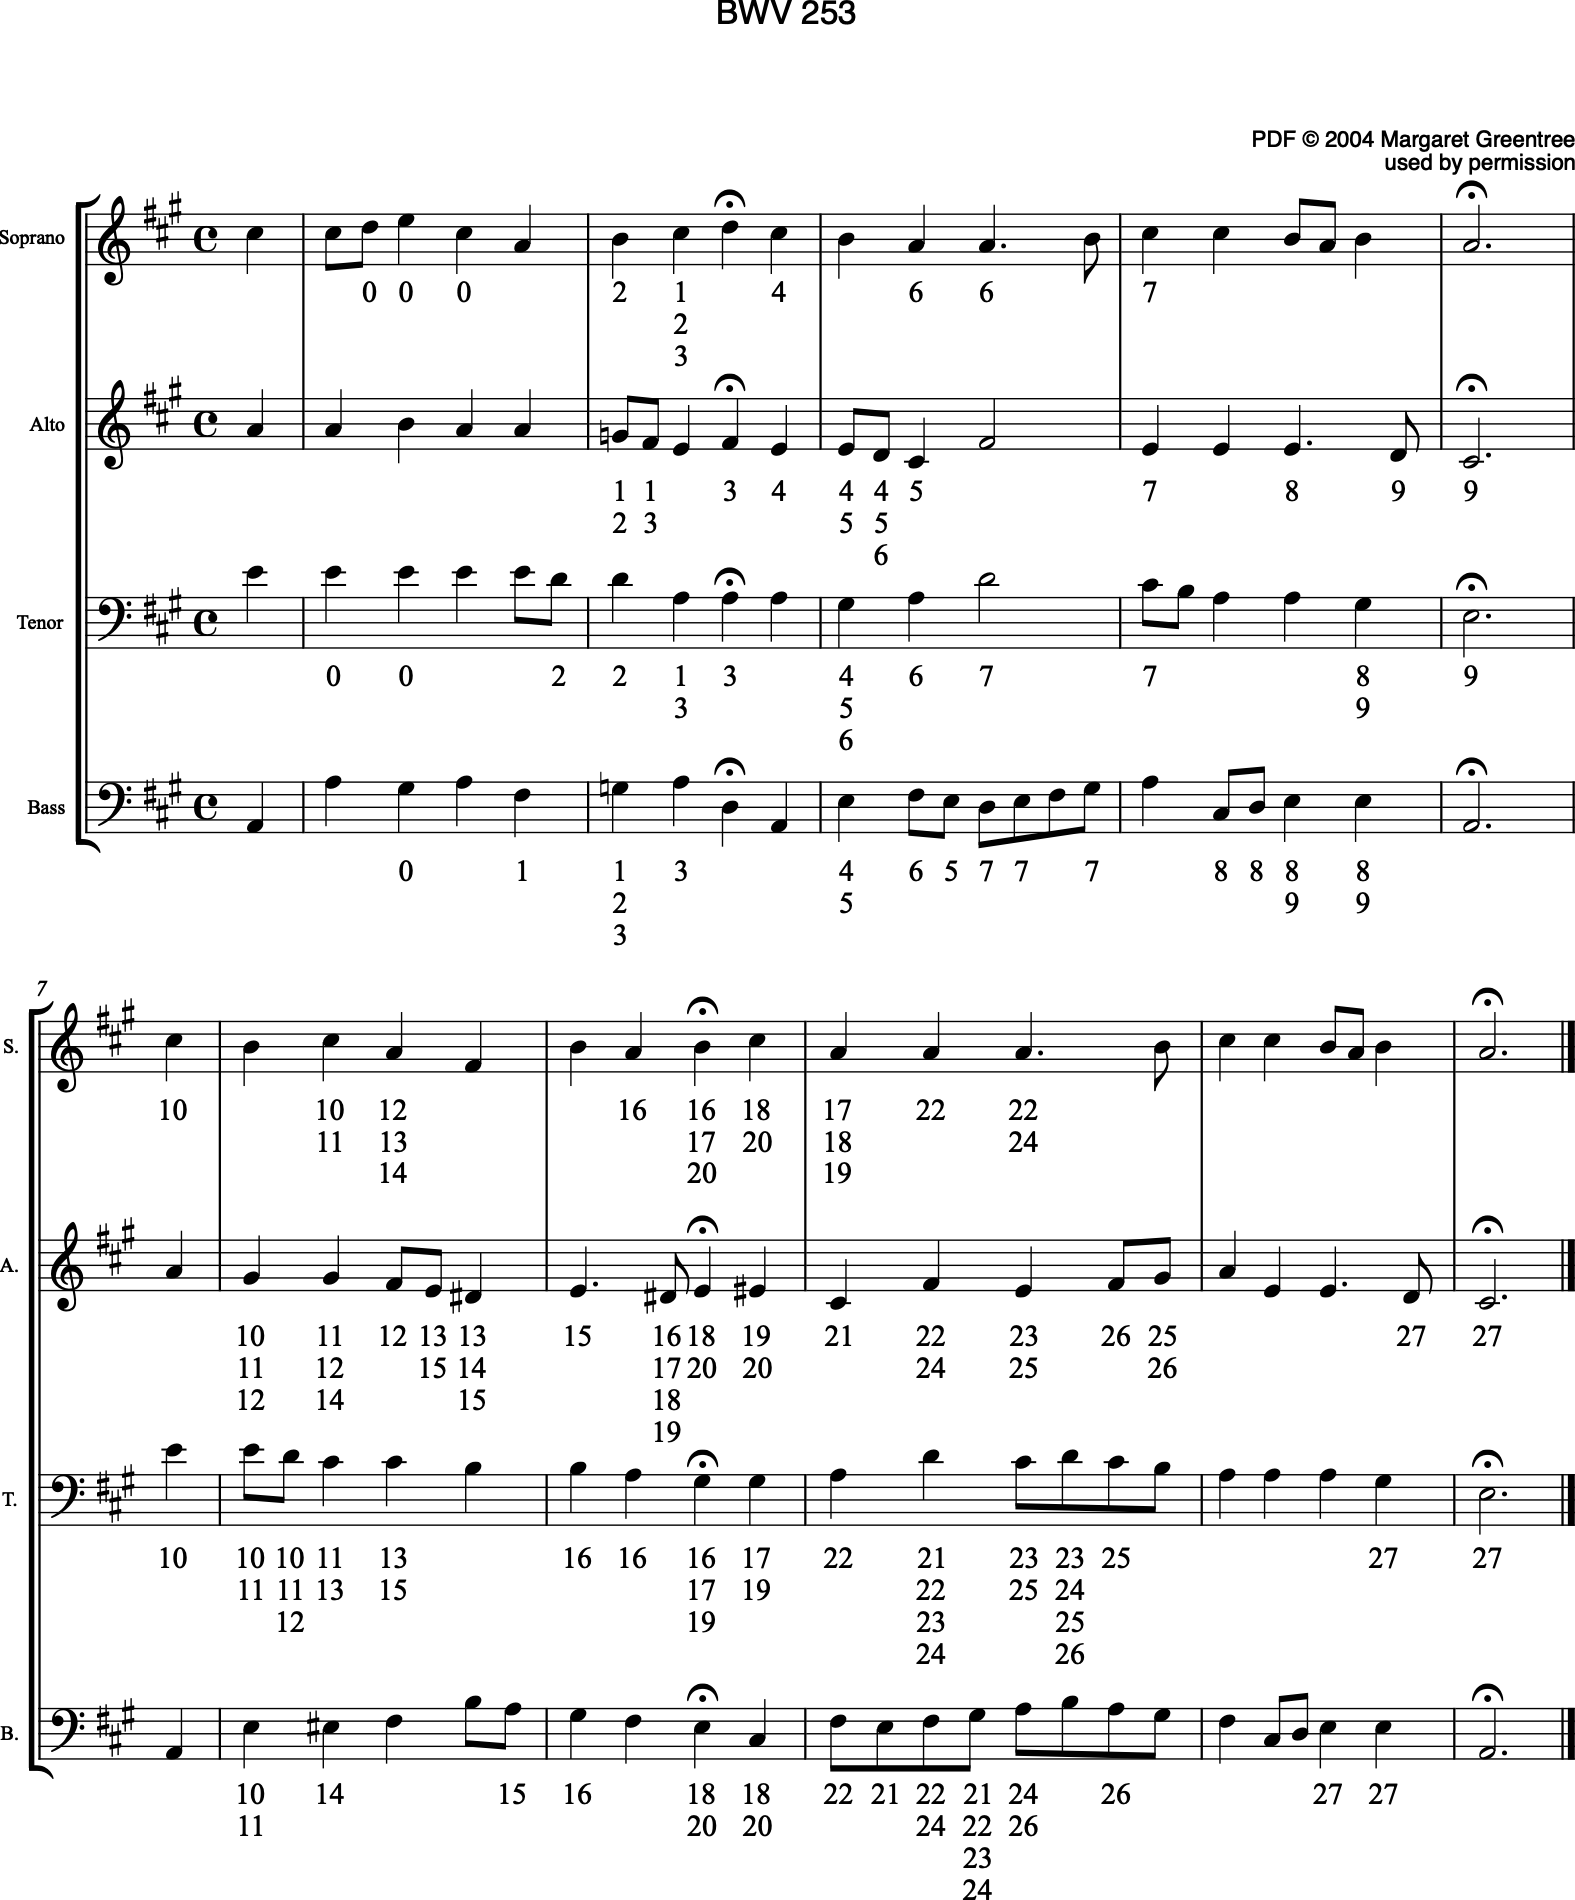

In [74]:
bach = corpus.parse('bwv253')
find_Z_relation(bach, 10, 'notes')
# print('test')
bach.show()

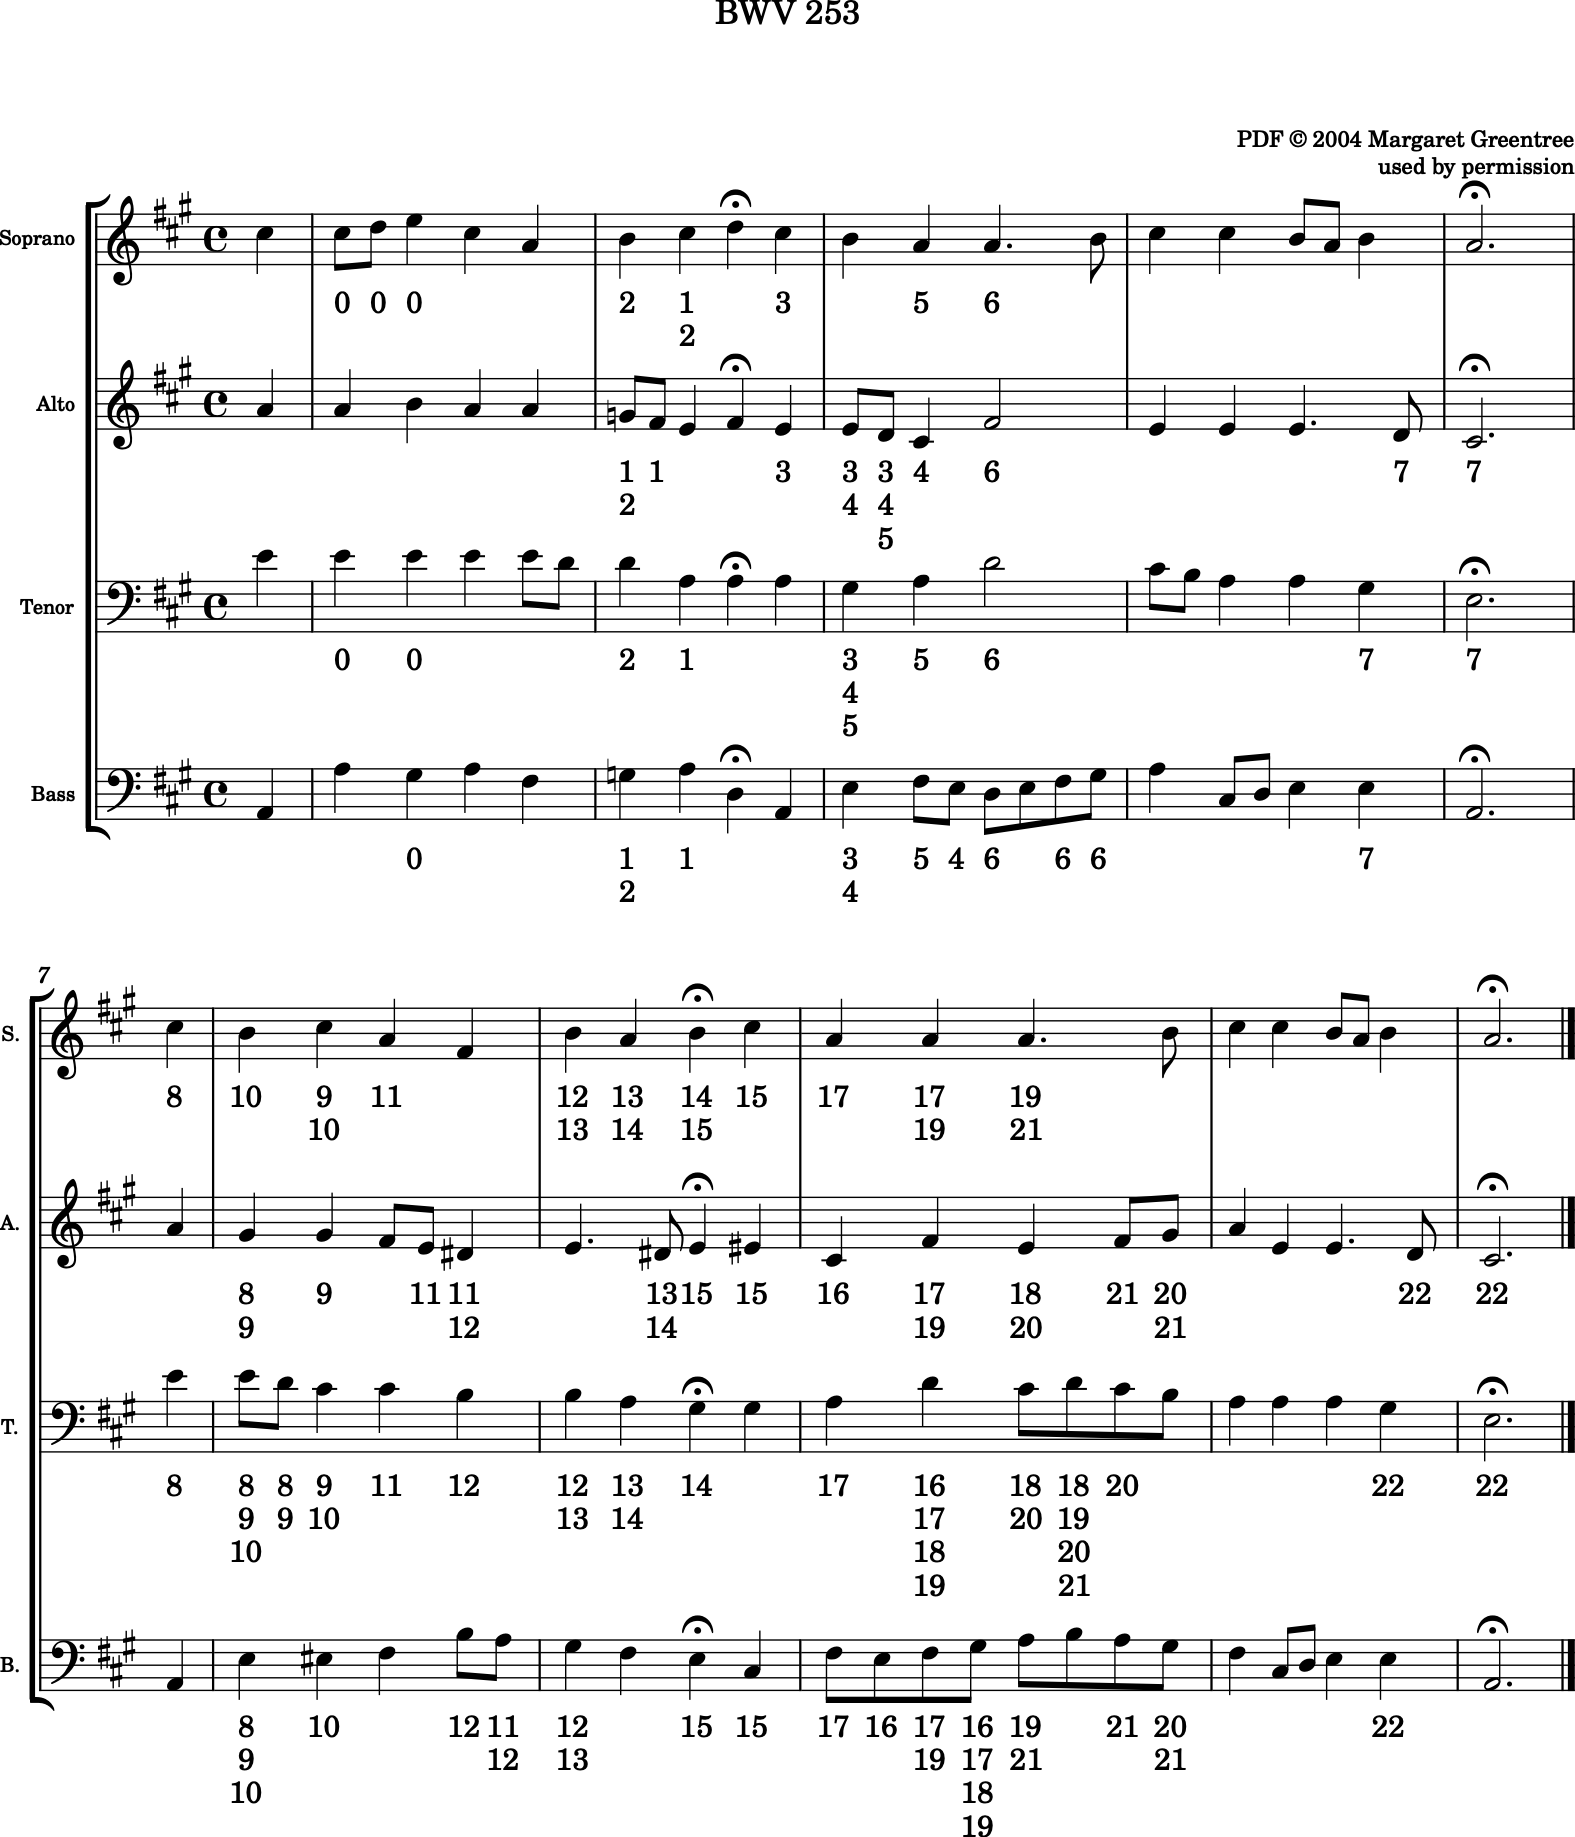

In [ ]:
bach = corpus.parse('bwv253')
find_Z_relation(bach, 2, 'quarterLengths')
# print('test')
bach.show()

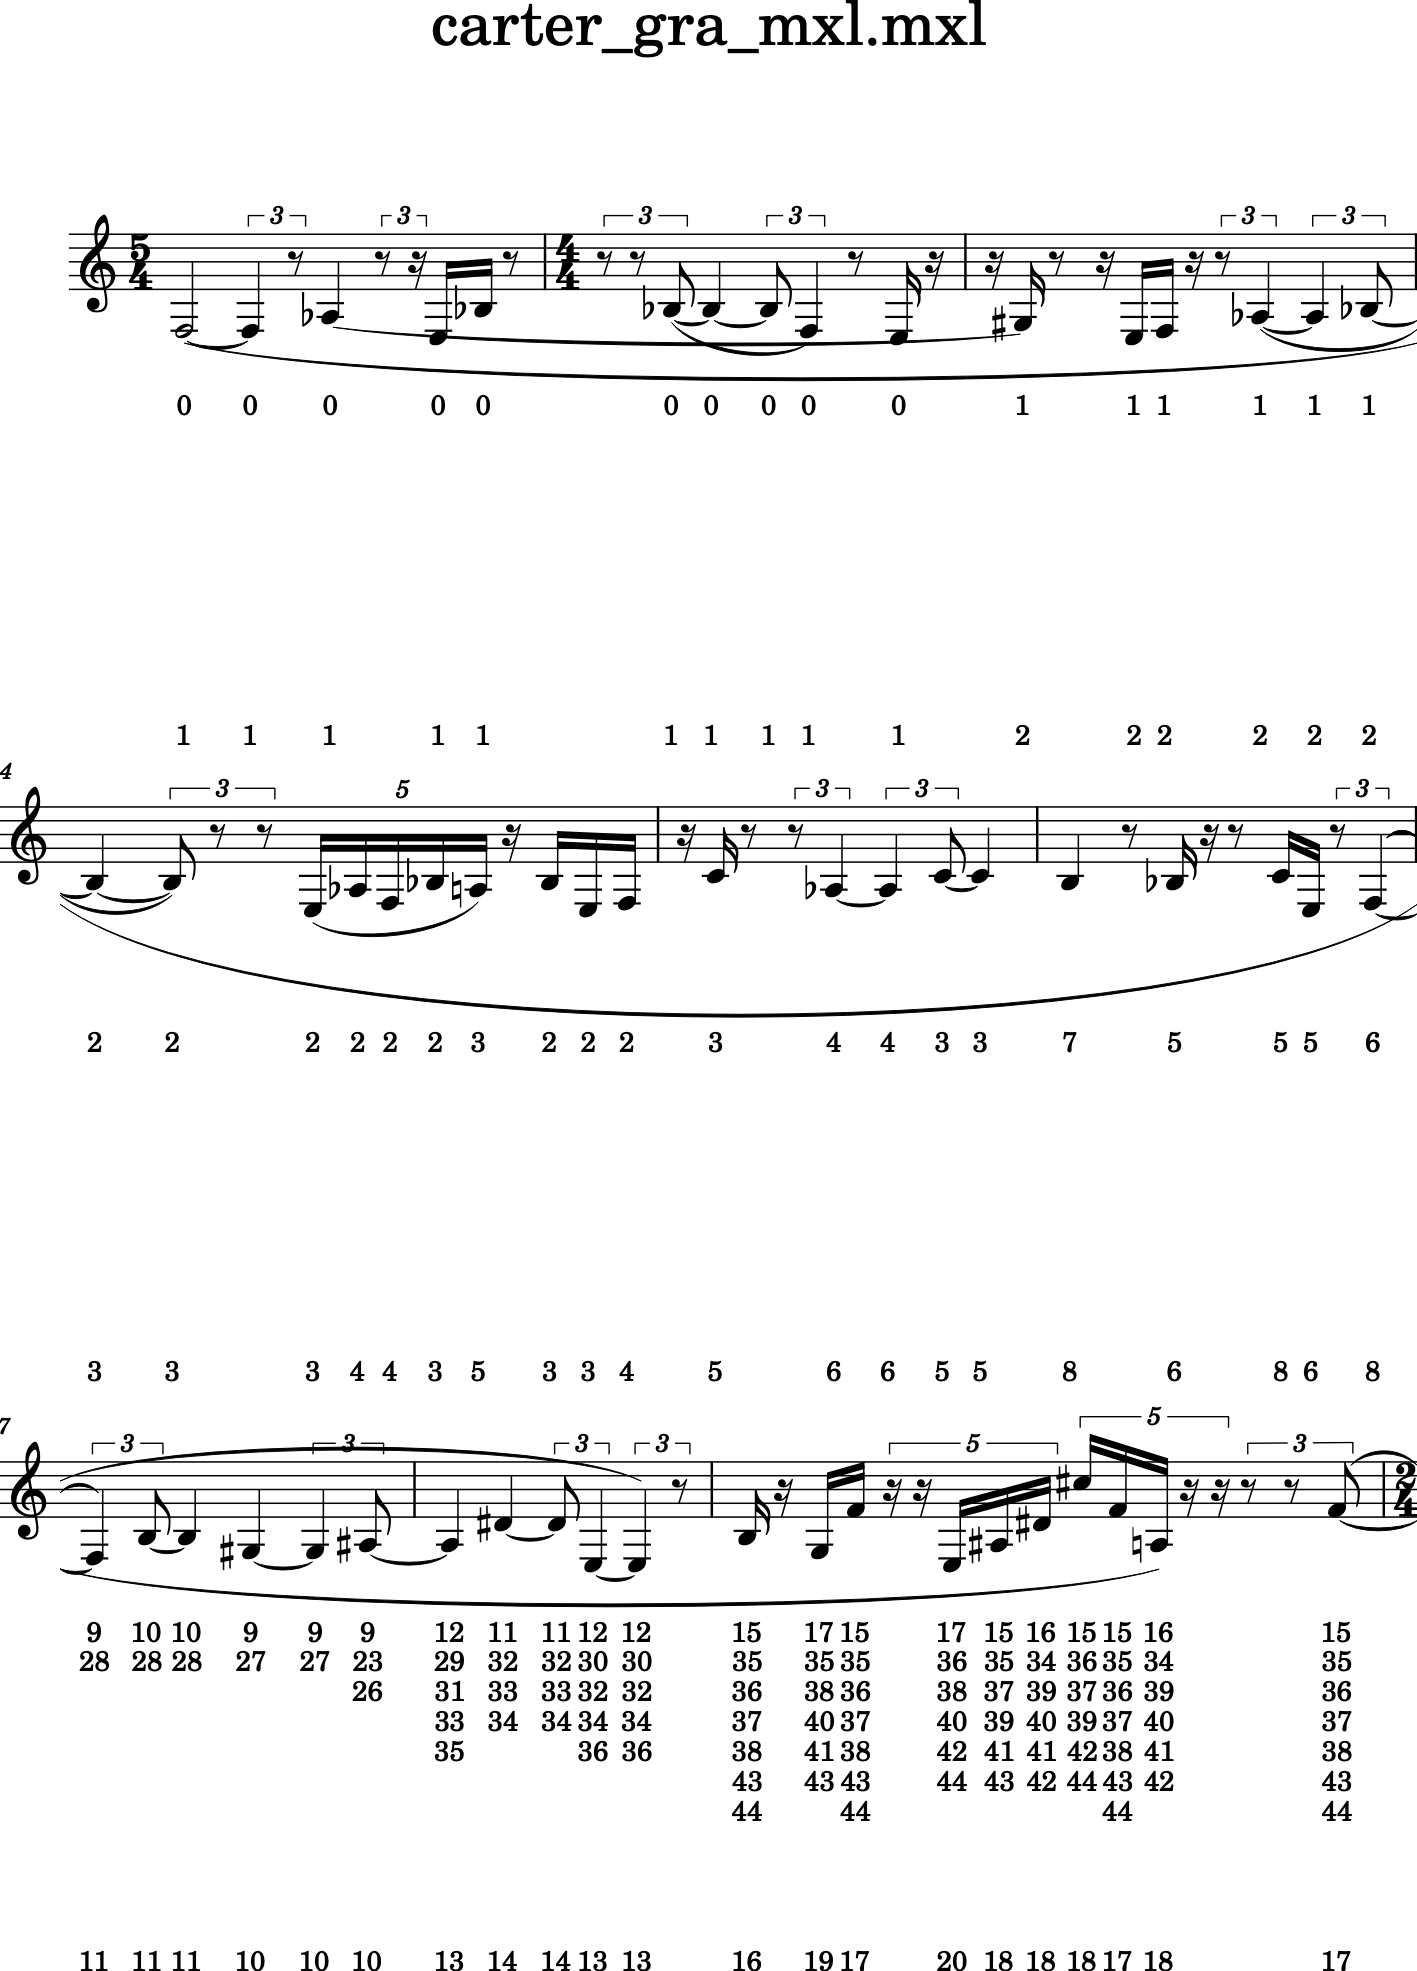

In [75]:
carter.measures(0, 20).show()

In [77]:
# check_window(bach.measures(0,3))
# print('test')